# Deep Learning for Computer Vision:  Assignment 5

## Computer Science: COMS W 4995 004

## Due: April 6, 2017

### Problem: Telling Cats from Dogs using VGG16

This assignment is based on the blog post
"Building powerful image classification models using very little data"
from blog.keras.io. Here you will build a classifier that can distinguish between pictures of dogs and cats. You will use a ConvNet (VGG16) that was pre-trained ImageNet. Your task will be to re-architect the network to solve your problem. To do this you will:
0. Make a training dataset, using images from the link below, with 10,000 images of cats and 10,000 images of dogs. Use 1,000 images of each category for your validation set. The data should be orgainized into folders named ./data/train/cats/ + ./data/train/dogs/ + ./data/validation/cats/ + ./data/validation/dogs/. (No need to worry about a test set for this assignment.)  
1. take VGG16 network architecture
2. load in the pre-trained weights from the link below for all layers except the last layers 
3. add a fully connected layer followed by a final sigmoid layer to replace the 1000 category softmax layer that was used when the network was trained on ImageNet
4. freeze all layers except the last two that you added
5. fine-tune the network on your cats vs. dogs image data
6. evaluate the accuracy
7. unfreeze all layers
8. continue fine-tuning the network on your cats vs. dogs image data
9. evaluate the accuracy
10. comment your code and make sure to include accuracy, a few sample mistakes, and anything else you would like to add

Downloads:
1. You can get your image data from:
https://www.kaggle.com/c/dogs-vs-cats/data. 
2. You can get your VGG16 pre-trained network weights from 
https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

(Note this assignment deviates from blog.keras.io in that it uses more data AND performs the fine-tuning in two steps: first freezing the lower layers and then un-freezing them for a final run of fine-tuning. The resulting ConvNet gets more than 97% accuracy in telling pictures of cats and dogs apart.)

A bunch of code and network definition has been included to to get you started. This is not meant to be a difficult assignment, as you have your final projects to work on!  Good luck and have fun!

Here we import necessary libraries.

In [1]:
import os
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


We only have two classes.

In [2]:
nb_classes = 2
class_name = {
    0: 'cat',
    1: 'dog',
}

This let's us plot samples.

In [3]:
def show_sample(X, y, prediction=-1):
    im = X
    plt.imshow(im)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('on')
    plt.show()

Here we define where the data comes from and how much we have.

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './data/train'
validation_data_dir = './data/validation'
nb_train_samples = 20000
nb_validation_samples = 2000

Keras training requires specifying how the data is going to be streamed
to to the "fitting" routine. Here the data is augmented with "new" examples which 
are sheared, zoomed, and flipped versions of the originals.

In [5]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Let's display some sample images from this dataset. Note that these are real images and this is not an easy problem. But also note that it is made simpler by the fact that the animals, for the most part, are relatively large and centered in the photos.

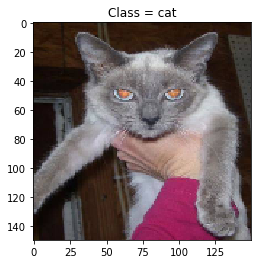

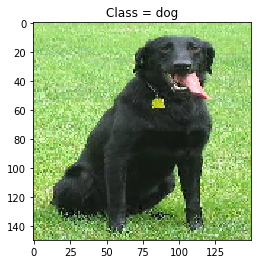

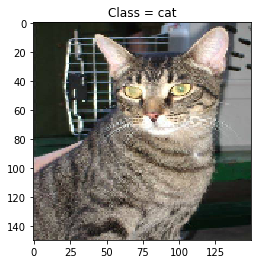

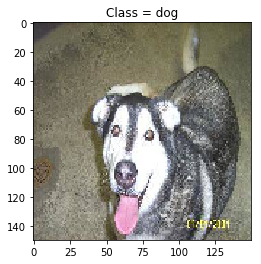

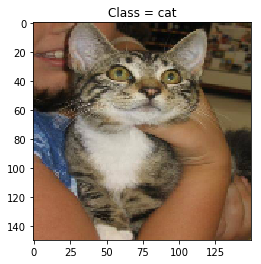

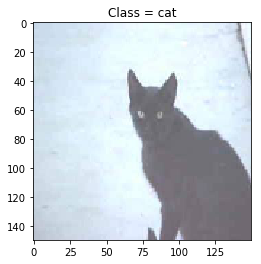

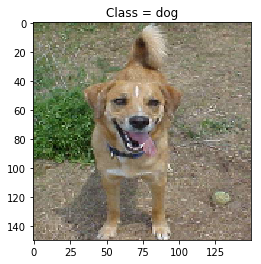

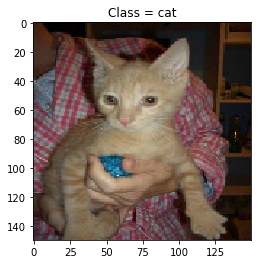

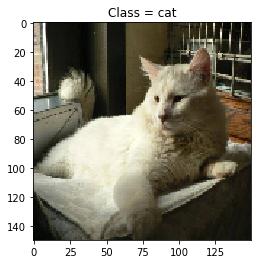

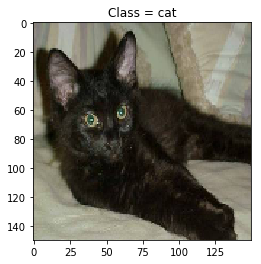

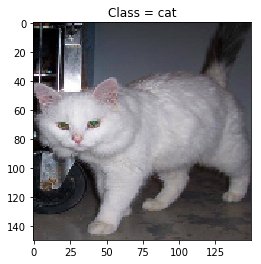

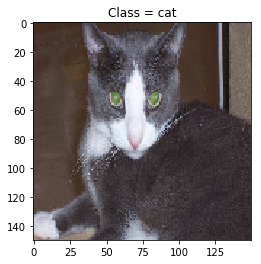

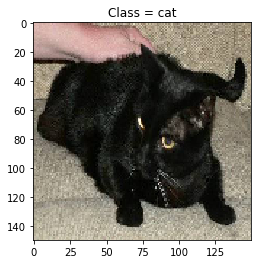

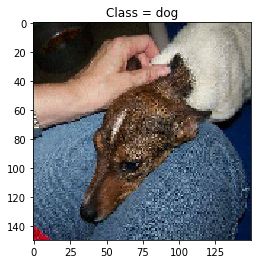

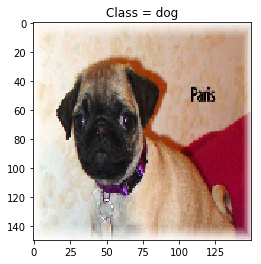

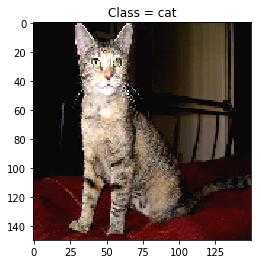

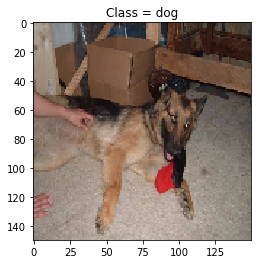

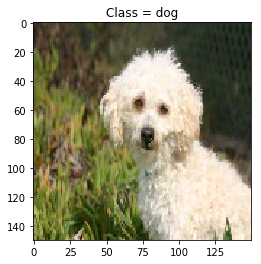

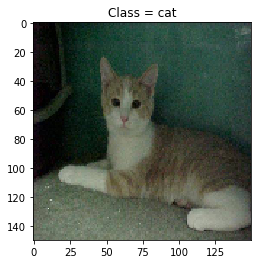

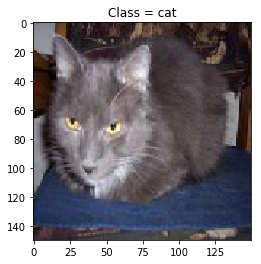

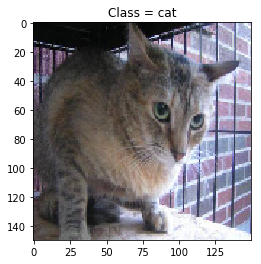

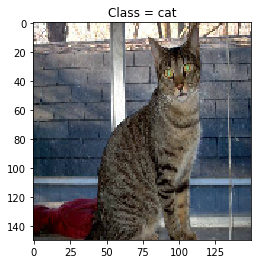

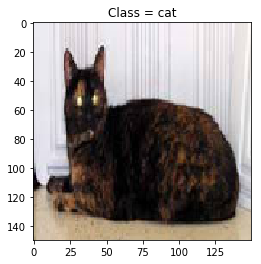

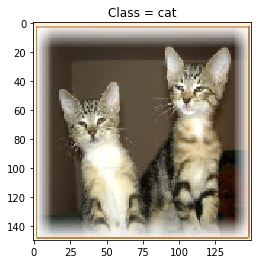

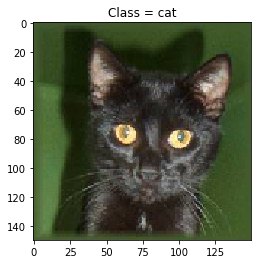

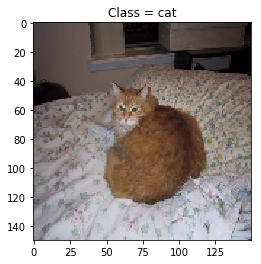

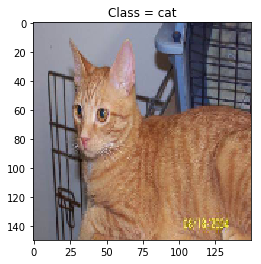

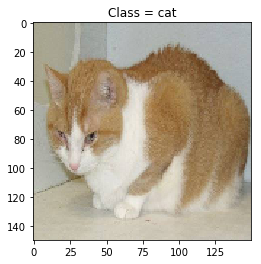

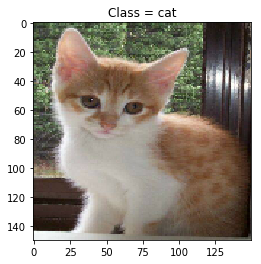

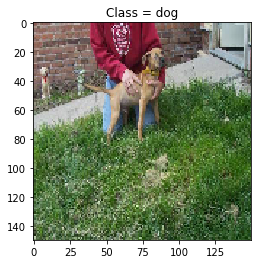

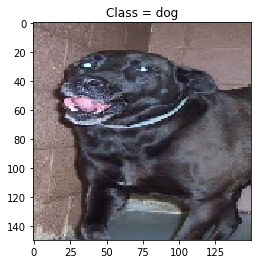

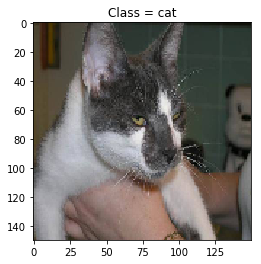

In [6]:
for X_batch, Y_batch in validation_generator:
    for i in range(len(Y_batch)):
        show_sample(X_batch[i, :, :, :], Y_batch[i])
    break

Here is our first model. It is a small ConvNet which does surprisingly well at the dog vs. cat problem. 
But we will be able to do much better later on. This network is not particularly deep, just three convolutional layers each with max pooling and a final fully connected layer.

In [37]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Now we compile the network using cross entropy loss on our logistic sigmoid and print out network layers.

In [38]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 148, 148, 32)  896         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 148, 148, 32)  0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_14 (MaxPooling2D)   (None, 74, 74, 32)    0           activation_6[0][0]               
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 72, 72, 32)    9248        maxpooling2d_14[0][0]            
___________________________________________________________________________________________

I was havinng permission troubles with creating dirs and writing files, so I jumped out to the shell to make these manually. These dirs will hold the training history, logging, and models created during training. 

In [39]:
%ls
%pushd
%mkdir -p history
%mkdir -p models
%mkdir -p logs
%cd logs 
%mkdir -p ./little_convnet
%mkdir -p ./vgg16_fine_tuning
%popd
%ls -la

data/  imagenet_vgg16_fine-tuning.ipynb  vgg16_weights.h5
/home/ubuntu/notebooks/imagenet_vgg16_fine-tuning/logs
/home/ubuntu/notebooks/imagenet_vgg16_fine-tuning
popd -> ~/notebooks/imagenet_vgg16_fine-tuning
total 544516
drwxr-xr-x  7 ubuntu ubuntu      4096 Mar  6 18:21 ./
drwxr-xr-x 10 ubuntu ubuntu      4096 Mar  2 20:06 ../
drwxr-xr-x  4 ubuntu ubuntu      4096 Feb 27 22:31 data/
-rw-r--r--  1 ubuntu ubuntu      8196 Mar  3 15:57 .DS_Store
drwxrwxr-x  2 ubuntu ubuntu      4096 Mar  6 18:21 history/
-rw-r--r--  1 ubuntu ubuntu   4058523 Mar  6 18:17 imagenet_vgg16_fine-tuning.ipynb
drwxr-xr-x  2 ubuntu ubuntu      4096 Feb 27 15:36 .ipynb_checkpoints/
drwxrwxr-x  4 ubuntu ubuntu      4096 Mar  6 18:21 logs/
drwxrwxr-x  2 ubuntu ubuntu      4096 Mar  6 18:21 models/
-rw-r--r--  1 ubuntu ubuntu 553479920 Mar  2 01:48 vgg16_weights.h5


Here we design the call backs that will record stuff while training. The first will create the log files that can be viewed using the command line tool Tensorboard. The second saves the "best model" so far, where best is based on the validation accuracy.

In [ ]:
tensorboard_callback = TensorBoard(log_dir='./logs/little_convnet/', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/little_convnet_weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

Now we are on to training the network. Note the use of the callbacks. Also note that the learning schedule was set back when we compiled the network.

In [ ]:
nb_epoch = 25

hist_little_convet = model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = 0,
        callbacks=[tensorboard_callback, checkpoint_callback]
)

pandas.DataFrame(hist_little_convet.history).to_csv("./history/little_convet.csv")

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/25
20000/20000 [==============================] - 149s - loss: 0.6203 - acc: 0.6541 - val_loss: 0.4963 - val_acc: 0.7620

Below we grab some validation batches and evaluate our accuracy. We achieve 85% with this little network, which ain't bad, but we can do MUCH better. 

In [ ]:
X_test, y_test = next(validation_generator)
predictions = model.predict_classes(X_test, batch_size=32, verbose=0)

In [ ]:
for i in range(15):
    show_sample(X_test[i, :, :, :], y_test[i], prediction=predictions[i, 0])

Now we move on to building a more powerful ConvNet: VGG16. We will not train it from scratch but rather load in the weights for the model from a pre-trained version, version that was trained on ImageNet. We will then chop of the last layer and replace it with one that fits our two class cat vs. dog problem. We will freeze the bottom layers of the network and only train the weights of the new last layer. Why? Because if we allow the whole model to train all the weights at once we might do damage to the carefully selected weights in the lower convolutional layers. So instead, we train only the top layer. This training produces a classifier that has 91% accuracy, which is quite an improvement over the last one. However, once this training converges, more or less, we then unfreeze the lower layers and let all the layers train. The final model gets 97% accuracy!

A slight inelegance arises here. The pre-trained model uses Theano style layer index orderings and we are using Tensorflow. So we have to make a Theano style model, load in the weights, make a Tensorflow style model, and then transfer the weights over. This makes what we are doing look more complicated than it acutally is!

The routine below make a VGG16 network in either Theano or Tensorflow style. The only difference is the ordering of the volume indices. Note that it does not make the last layeras this would have to be removed.

In [7]:
def build_vgg16(framework='tf'):

    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        backend.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        backend.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

In [30]:
# path to the model weights files.
weights_path = 'vgg16_weights.h5'
th_model = build_vgg16('th')


Now we load in the weights to the Theano style VGG16 model.

In [31]:
# load the weights of the VGG16 networks
# (trained on ImageNet, won the ILSVRC competition in 2014)
# note: when there is a complete match between your model definition
# and your weight savefile, you can simply call model.load_weights(filename)
assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(th_model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    layer = th_model.layers[k]

    #if layer.__class__.__name__ == 'Convolution2D':
        #weights[0] = np.transpose(weights[0], (2, 3, 1, 0))
    th_model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

Model loaded.


Then we build a Tensorflow style model and transfer over the weights.

In [32]:
tf_model = build_vgg16('tf')

In [33]:
# # transfer weights from th_model to tf_model
for th_layer, tf_layer in zip(th_model.layers, tf_model.layers):
    if th_layer.__class__.__name__ == 'Convolution2D':
      kernel, bias = th_layer.get_weights()
      kernel = np.transpose(kernel, (2, 3, 1, 0))
      tf_layer.set_weights([kernel, bias])
    else:
      tf_layer.set_weights(tf_layer.get_weights())

Next we make the last layer or layers. We flatten the output from the last convolutional layer, and add fully connected layer with 256 hidden units. Finally, we add the output layer which is has a scalar output as we have a binary classifier. 

In [34]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
print Flatten(input_shape=tf_model.output_shape[1:])
top_model.add(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
print (tf_model.summary())
print(top_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_66 (ZeroPadding2D) (None, 152, 152, 3)   0           zeropadding2d_input_6[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 150, 150, 64)  1792        zeropadding2d_66[0][0]           
____________________________________________________________________________________________________
zeropadding2d_67 (ZeroPadding2D) (None, 152, 152, 64)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 150, 150, 64)  36928       zeropadding2d_67[0][0]           
___________________________________________________________________________________________

We add this model to the top of our VGG16 network, freeze all the weights except the top, and compile.

In [35]:
# add the model on top of the convolutional base
tf_model.add(top_model)

In [36]:
#freeze all the weights except the top
for l in tf_model.layers:
    if l.__class__.__name__ == 'Sequential':
        break
    l.trainable = False
print (tf_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_66 (ZeroPadding2D) (None, 152, 152, 3)   0           zeropadding2d_input_6[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 150, 150, 64)  1792        zeropadding2d_66[0][0]           
____________________________________________________________________________________________________
zeropadding2d_67 (ZeroPadding2D) (None, 152, 152, 64)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 150, 150, 64)  36928       zeropadding2d_67[0][0]           
___________________________________________________________________________________________

Now we train for 5 epochs to get the weights for the top close to where we need them. Essentially, we want the network to be doing the right thing before we unnfreeze the lower weights.

In [37]:
#using adamax as optimizer for the reason that it can adapt to the new data quickly
tf_model.compile(loss = 'binary_crossentropy',
              optimizer = 'Adamax',
              metrics=['accuracy'])

nb_epoch = 5
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')
# we will save the best model for the following training
checkpoint_callback = ModelCheckpoint('vgg_freeze_new_weights.best.hdf5', monitor='val_acc', save_best_only=True)

#fit the model
vgg_freeze_convet = tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples // batch_size,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples // batch_size,
        verbose = 1,
        initial_epoch = 0,
        callbacks = [checkpoint_callback]
)



Found 20000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/5
640/625 [==============================] - 304s - loss: 1.1639 - acc: 0.5953 - val_loss: 0.7455 - val_acc: 0.6719
Epoch 2/5
640/625 [==============================] - 311s - loss: 0.5717 - acc: 0.7141 - val_loss: 0.4655 - val_acc: 0.7656
Epoch 3/5
640/625 [==============================] - 329s - loss: 0.4789 - acc: 0.7750 - val_loss: 0.5202 - val_acc: 0.7500
Epoch 4/5
640/625 [==============================] - 265s - loss: 0.4507 - acc: 0.7953 - val_loss: 0.3365 - val_acc: 0.9219
Epoch 5/5
640/625 [==============================] - 266s - loss: 0.4144 - acc: 0.8094 - val_loss: 0.2829 - val_acc: 0.8906


Running this, we see that it gets 91% accuracy on the validation set, so we have almost halved the errors from before.

In [53]:
#test our model, it can reach nearly 91% accuracy
accuracies = np.array([])
losses = np.array([])
i=0
best_model = load_model('vgg_freeze_new_weights.best.hdf5')
for X_batch, Y_batch in validation_generator:
    loss, accuracy = best_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
        break
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

Validation: accuracy = 0.906250  ;  loss = 0.392637


Now we can unnfreeze the lower layers.

In [67]:
#use the best model we trained
unfreeze_model = load_model('vgg_freeze_new_weights.best.hdf5')
#unnfreeze the lower layers
for l in unfreeze_model.layers:
    l.trainable = True
#print (unfreeze_model.summary())

In [68]:
vgg_unfreeze_checkpoint_callback = ModelCheckpoint('vgg_unfreeze_new_weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True)
unfreeze_model.compile(loss = 'binary_crossentropy',
              optimizer= optimizers.Adamax(lr=1e-5),
              metrics=['accuracy'])

nb_epoch = 5
batch_size = 32
#fit our model
vgg_unfreeze_convet = unfreeze_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples // batch_size, 
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples // batch_size, 
        verbose = 1,
        initial_epoch = 0,
        callbacks=[vgg_unfreeze_checkpoint_callback]
)


Epoch 1/10
640/625 [==============================] - 713s - loss: 0.3911 - acc: 0.8438 - val_loss: 0.3648 - val_acc: 0.8750
Epoch 2/10
640/625 [==============================] - 814s - loss: 0.3703 - acc: 0.8359 - val_loss: 0.2367 - val_acc: 0.8750
Epoch 3/10
640/625 [==============================] - 789s - loss: 0.3578 - acc: 0.8609 - val_loss: 0.2299 - val_acc: 0.9062
Epoch 4/10
640/625 [==============================] - 703s - loss: 0.3430 - acc: 0.8469 - val_loss: 0.3084 - val_acc: 0.8906
Epoch 5/10
640/625 [==============================] - 736s - loss: 0.2807 - acc: 0.8891 - val_loss: 0.2800 - val_acc: 0.8594
Epoch 6/10
640/625 [==============================] - 745s - loss: 0.3074 - acc: 0.8781 - val_loss: 0.1947 - val_acc: 0.9375
Epoch 7/10
640/625 [==============================] - 706s - loss: 0.3087 - acc: 0.8703 - val_loss: 0.3821 - val_acc: 0.8438
Epoch 8/10
640/625 [==============================] - 760s - loss: 0.2902 - acc: 0.8719 - val_loss: 0.2314 - val_acc: 0.8594


We will let this train for 10 epochs.

We get to 96% accuracy! But it looks like we stopped it a bit early...

In [71]:
#test our model and in the best siuation, we can reach the 96% accuracy
accuracies = np.array([])
losses = np.array([])
best_model = load_model('vgg_unfreeze_new_weights.05-0.94.hdf5')
for j in range(3):
    i=0
    for X_batch, Y_batch in validation_generator:
        loss, accuracy = best_model.evaluate(X_batch, Y_batch, verbose=0)
        losses = np.append(losses, loss)
        accuracies = np.append(accuracies, accuracy)
        i += 1
        if i == 20:
            break
    print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

Validation: accuracy = 0.968750  ;  loss = 0.167322
Validation: accuracy = 0.937500  ;  loss = 0.203368
Validation: accuracy = 0.937500  ;  loss = 0.191338


In [46]:
#at lastt, we tune a little bit.
#vgg_unfreeze_new_weights.05-0.94.hdf5
tunning_model = load_model('vgg_unfreeze_new_weights.05-0.94.hdf5')
#unfreeze the last conv block and top layer
for l in tunning_model.layers:
    if l.__class__.__name__ == 'Sequential':
        break
    l.trainable = False
#print (tunning_model.summary())


In [47]:
vgg_tunning_checkpoint_callback = ModelCheckpoint('vgg_tunning_weights.best.hdf5', monitor='val_acc', verbose=0, save_best_only=True)
tunning_model.compile(loss = 'binary_crossentropy',
              optimizer= optimizers.Adamax(lr=1e-6),
              metrics=['accuracy'])

nb_epoch = 3
batch_size = 32
vgg_tunning_convet = tunning_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples // batch_size, 
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples // batch_size, 
        verbose = 1,
        initial_epoch = 0,
        callbacks=[vgg_tunning_checkpoint_callback]
)


Epoch 1/3
640/625 [==============================] - 278s - loss: 0.3091 - acc: 0.8641 - val_loss: 0.3379 - val_acc: 0.8438
Epoch 2/3
640/625 [==============================] - 273s - loss: 0.3089 - acc: 0.8734 - val_loss: 0.2603 - val_acc: 0.8438
Epoch 3/3
640/625 [==============================] - 259s - loss: 0.3220 - acc: 0.8594 - val_loss: 0.1779 - val_acc: 0.9531


We let it go one last time and see that it pushes up just a bit higher to 97%. Also note that it looks like it is beginning to overfit as the training loss is coming way down and the training accuracy is going well beyond the validation accuracy.

In [51]:
accuracies = np.array([])
losses = np.array([])
i=0
best_model = load_model('vgg_tunning_weights.best.hdf5')

for X_batch, Y_batch in validation_generator:
    loss, accuracy = tunning_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 10:
        break
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

Validation: accuracy = 0.900000  ;  loss = 0.241392


Wow! 97% accuracy! And we are done...